<a href="https://colab.research.google.com/github/TheoBertrand-Dauphine/MVA_NT_geodesic_methods/blob/main/TP3/TP3-Levelset-MVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 3 - Active Contours using Level Sets

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This lab explores image segmentation using level set methods. Here is the outline of the lab, the links will help you navigate the notebook

1. [Managing level set functions](#1.-Managing-level-set-functions): this part will help you manage level sets in a proper way
2. [Mean Curvature Motion](#2.-Mean-Curvature-Motion): you will implement the Mean Curvature Motion for an active contour
3. [Edge-based Segmentation with Geodesic Active Contour](#3.-Edge-based-Segmentation-with-Geodesic-Active-Contour): using the previous algorithm to segment images, minimizing an energy defined by the edges
4. [Region-based Segmentation with Chan-Vese](#4.-Region-based-Segmentation-with-Chan-Vese): replacing the previous energy by one defined by the whole segmented region

In [2]:
!git clone https://github.com/TheoBertrand-Dauphine/MVA_NT_geodesic_methods

%cd MVA_NT_geodesic_methods

from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
import sys

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Cloning into 'MVA_NT_geodesic_methods'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 347 (delta 0), reused 0 (delta 0), pack-reused 345
Receiving objects: 100% (347/347), 24.10 MiB | 19.96 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/MVA_NT_geodesic_methods


## 1. Managing level set functions

In the level set formalism, the evolution of some curve $ (\ga(t))_{t=0}^1 $
is computed by evolving the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\ga(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$
This corresponds to replacing the parameteric representation $\ga$ of
the curve by an implicit representation. This requires an additional
dimension (and hence more storage) but ease the handling of topological
change of the curve during the evolution.

To represent such functions $\phi$, we will discretize the domain $[0,1]^2$ into $n \times n$ pixels: $\phi$ is now simply an image

In [3]:
n = 200
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))

One can create a circular shape by using the signed distance function to
a circle
$$ \phi_1(x) = \sqrt{ (x_1-c_1)^2 + (x_2-c_2)^2 } - r $$
where $r>0$ is the radius and $c \in \RR^2$ the center.

__Exercise 1__

- Create a circle shape $\phi_1$ using $(r,c)$ values provided below. Name the variable `phi1`
- Load a square shape $\phi_2$ at a different position for the center. Name it `phi2`

In [4]:
r = n/3.
c = np.array([r,r]) + 10
phi1 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

c = c + np.array([30,30])
phi2 = np.maximum(np.abs(X-c[0]),np.abs(Y-c[1])) - r/2

Display the curves associated to $\phi_1$ and $\phi_2$, using a util function from the toolboxes

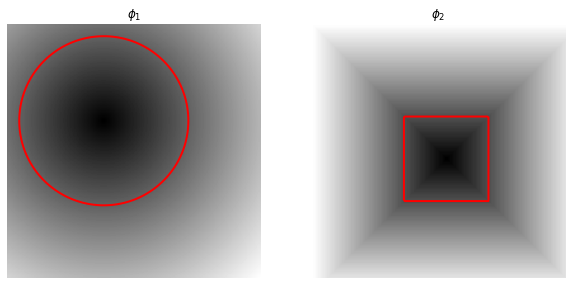

In [5]:
from nt_toolbox.plot_levelset import *
plt.figure(figsize = (10,5)) # the argument figsize is in centimeters

plt.subplot(1,2,1)
plot_levelset(phi1)
plt.title("$\phi_1$")

plt.subplot(1,2,2)
plot_levelset(phi2)
plt.title("$\phi_2$")

plt.show()

__Exercise 2__

Compute the intersection and the union of the two shapes. Store the union in $\phi_0$ (`phi0`) that we will use in the remaining part of the tour. Don't forget to plot the result

Text(0.5, 1.0, '$\\phi_0$')

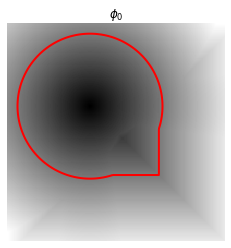

In [6]:
## Union
phi0 = np.minimum(phi1,phi2)

plot_levelset(phi0)
plt.title("$\phi_0$")

Text(0.5, 1.0, '$\\phi_0$')

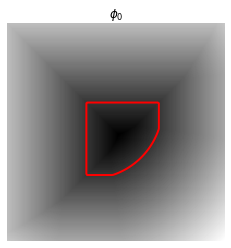

In [7]:
## Intersection
phi0 = np.maximum(phi1,phi2)

plot_levelset(phi0)
plt.title("$\phi_0$")

## 2. Mean Curvature Motion

The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ \int_0^1 \norm{\ga'(s)} d s. $$



It is implemeted in a level set formalism by a familly $\phi_t$ of
level set function parameterized by an artificial time $t \geq 0$, that
satisfies the following PDE
$$ \pd{\phi_t}{t} = -G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}} }  $$
and where $\nabla \phi_t(x) \in \RR^2$ is the spacial gradient.


This flow is computed using a gradient descent
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step.

We need to define parameters for the algorithm:

- Maximum time of the evolution $0 \leq t \leq t_{\max}$
- Time step $\tau>0$ (should be small)
- Number of iterations

We also import util functions from the toolbox

In [8]:
from nt_toolbox.grad import *
from nt_toolbox.div import *

Tmax = 200
tau = .5
niter = int(Tmax/tau)

For the initial shape $\phi^{(0)}$ at $t=0$, we copy `phi0` (since numpy holds data pointers)

In [9]:
phi = np.copy(phi0)

__\*\*\* Exercise 3 \*\*\* (a.k.a. the most important one in this lab)__

Implement the mean curvature motion for $\phi_0$. Some tips :

- The toolbox will help you compute the gradient: `grad(f, order=2)`
- To normalize the gradient, you might need the following functions: `np.repeat()` and `np.sqrt(np.sum(g**2, 2))`
- Don't forget to cap $\norm{\nabla \phi}$ above $\epsilon$ in order to prevent division by 0. You can use `eps = np.finfo(float).eps` to get a value for $\epsilon$
- For divergence of `g`: `div(g[:,:,0], g[:,:,1], order=2)`
- It is an iterative algorithm, first implement one step and check it
- Then loop it up
- Display the result over time. You can for instance display 4 steps in total, using the `plt.subplot()` method seen above

Text(0.5, 1.0, '$\\phi_0$')

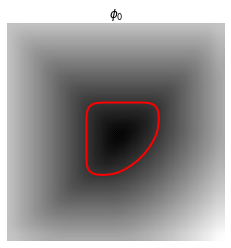

In [10]:
eps = np.finfo(float).eps

tau=0.1

Niter = 200

phi = np.copy(phi0)
for i in range(Niter):
    grad_phi = grad(phi, order=2)
    norm_grad_phi = np.sqrt(np.sum(grad_phi**2, 2))
    normalized_gradient = grad_phi/(np.repeat(norm_grad_phi[:,:,np.newaxis],2,axis=-1)+eps)
    G = -norm_grad_phi*div(normalized_gradient[:,:,0],normalized_gradient[:,:,1],order=2)

    phi = phi-tau*G


plot_levelset(phi)
plt.title("$\phi_0$")

Levelset Re-distancing
----------------------
During PDE resolution, a level set function $\phi$ might become
ill-conditionned, so that the zero crossing is not sharp enough.
The quality of the level set function is restored by computing the
signed distance function to the zero level set.


This corresponds to first extracting the zero level set
$$ \Cc = \enscond{x \in \RR^2 }{\phi(x)=0},  $$
and then computing $\tilde \phi(x)$, the signed distance function to $\Cc$, using Fast Marching. Then one can replace $\phi$ by $\text{sign}(\phi(x))\tilde \phi(x)$

To illustrate re-distancing, we set $\phi=\phi_0^3$ so that they are both valid level set function
of the same curve, but $\phi$ is not the signed distance function.

In [11]:
phi = phi0**3

You have two ways of running Fast Marching:

1. Use your implementation from previous lab
2. Use a util function from the toolbox. You need the python package scikit-fmm to run this function (`pip install scikit-fmm` in the console). Note that you might also need a C++ compiler (for Windows: https://wiki.python.org/moin/WindowsCompilers#Microsoft_Visual_C.2B-.2B-_14.0_standalone:_Visual_C.2B-.2B-_Build_Tools_2015_.28x86.2C_x64.2C_ARM.29).

In [14]:
!pip install scikit-fmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.2/438.2 KB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-fmm: filename=scikit_fmm-2022.8.15-cp38-cp38-linux_x86_64.whl size=271652 sha256=6ea15035a8d6c94492b71d185109ec2122cf61fe3ab20ea3cd1ce98971fdda0c
  Stored in directory: /root/.cache/pip/wheels/23/5b/cf/00eee57aa425649cb96fbdf99b1adff0be82bd70e125f2807e
Successfully built scikit-fmm


In [15]:
from nt_toolbox.perform_redistancing import *
phi1 = perform_redistancing(phi0)

Display the level sets.

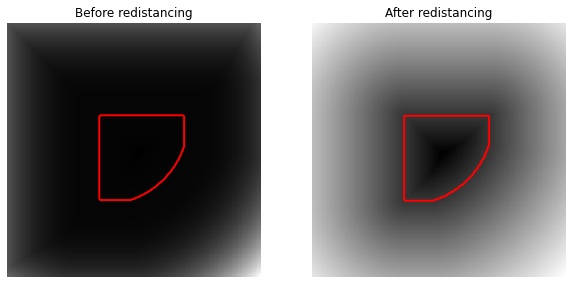

In [16]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plot_levelset(phi)
plt.title("Before redistancing")

plt.subplot(1,2,2)
plot_levelset(phi1)
plt.title("After redistancing")

plt.show()

## 3. Edge-based Segmentation with Geodesic Active Contour

Geodesic active contours compute local minimum of a weighted geodesic
distance that attracts the curve toward the features of the background
image.


_Note:_ these active contours should not be confounded with the geodesic shortest paths,
that are globally minimizing geodesics between two points.
Here the active contour is a closed curve progressively decreasing a
weighted geodesic length that is only a local minimum
(the global minimum would be a single point).


Size of the image.

In [17]:
n = 200

First we load an image $f_0 \in \RR^{n \times n}$ to segment.

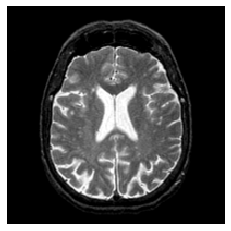

In [18]:
f0 = rescale(load_image("nt_toolbox/data/cortex.bmp", n))
imageplot(f0)

> __Warning__
>
> If the previous cell imports the image in black and white only (because of integer rounding), execute the following block instead

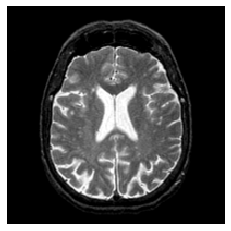

In [19]:
from skimage import transform
f0 = load_image("nt_toolbox/data/cortex.bmp", resc=0)
f0 = transform.resize(f0/765, [n, n], 1)
imageplot(f0)

Given a background image $f_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of large gradient.


We use here
$$ W(x) = \al + \frac{\be}{\epsilon + d(x) }
      \qwhereq d = \norm{\nabla f_0} \star h_a, $$
and where $h_a$ is a blurring kernel of size $a>0$.


Compute the magnitude of the gradient $d_0(x) = \norm{\nabla f_0(x)}$.

In [20]:
g = grad(f0, order=2)
d0 = np.sqrt(np.sum(g**2, 2))

Blur size $a$.

In [21]:
a = 5

Compute the blurring $d = d_0 \star h_a$.

In [22]:
from nt_toolbox.perform_blurring import *
# d = perform_blurring(d0,np.asarray([a]),bound="per")
d = signal.convolve2d(d0, np.exp(-(((X-1)/n -0.5)**2+((Y-1)/n-0.5)**2)/(0.05**2)), boundary='symm', mode='same')

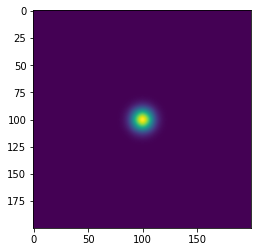

In [23]:
plt.imshow(np.exp(-(((X-1)/n -0.5)**2+((Y-1)/n-0.5)**2)/(0.05**2)))

Parameter $\epsilon>0$.

In [24]:
epsilon = 1e-1

We set the $\al$ and $\be$ parameters to adjust the overall values of $W$
(equivalently we use the function rescale).

In [25]:
W = 1./(epsilon + d)
W = rescale(-d, 0.1, 1)

Display it.

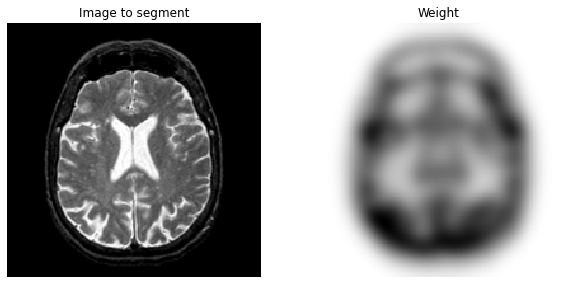

In [26]:
plt.figure(figsize=(10,5))
imageplot(f0, "Image to segment", [1,2,1])
imageplot(W, "Weight", [1,2,2])

__Exercise 4__

Compute an initial shape $\phi_0$ at time $t=0$,
for instance a centered square.

In [27]:
## Insert your code here.

phi0 = np.maximum(np.abs((X-1)/n -0.5),np.abs((Y-1)/n -0.5)) - 0.3

Display it.

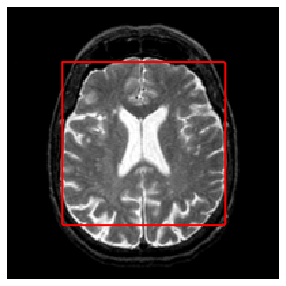

In [28]:
plt.figure(figsize=(5,5))
plot_levelset(phi0, 0, f0)

The geodesic active contour minimizes a weighted length of curve
$$ \umin{\ga} \int_0^1 \norm{\ga'(s)} W(\ga(s)) d s $$


The level set implementation of the gradient descent of this energy reads
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}\pa{
          W \frac{\nabla \phi}{\norm{\nabla \phi}}
  } $$


This is implemented using a gradient descent scheme.
$$ \phi^{(\ell+1)} = \phi^{(\ell)} + \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough.

Parameters:

In [29]:
tau = .4
Tmax = 1500
niter = int(Tmax/tau)

Note that we can re-write the gradient of the energy as
$$ G(\phi) = -W \norm{\nabla \phi} \text{div} \pa{ \frac{\nabla \phi}{\norm{\nabla \phi}}  } - \dotp{\nabla W}{\nabla \phi} $$


Also note that $\nabla W$ is contant over time and can be computed once and for all.

__Exercise 5__

Implement the geodesic active contours gradient descent.
Do not forget to do the re-distancing once in a while (e.g. every 30 iterations)

In [30]:
eps = np.finfo(float).eps

tau=0.7

Niter = 5000

phi = np.copy(phi0)
for i in range(Niter):
    grad_phi = grad(phi, order=2)
    norm_grad_phi = np.sqrt(np.sum(grad_phi**2, 2))
    normalized_gradient = grad_phi/(np.repeat(norm_grad_phi[:,:,np.newaxis],2,axis=-1)+eps)
    
    grad_W = grad(W, order=2)
    G = -W*norm_grad_phi*div(normalized_gradient[:,:,0],normalized_gradient[:,:,1],order=2) - grad_W[:,:,0]*grad_phi[:,:,0] - grad_W[:,:,1]*grad_phi[:,:,1]

    phi = phi-tau*G
    
    if i%10==0:
        phi = perform_redistancing(phi)
    


Text(0.5, 1.0, '$\\phi_0$')

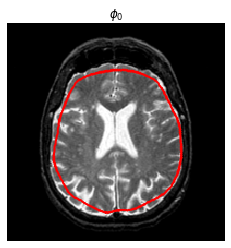

In [31]:
plot_levelset(phi,0,f0)
plt.title("$\phi_0$")

## 4. Region-based Segmentation with Chan-Vese 

Chan-Vese active contours corresponds to a region-based energy
that looks for a piecewise constant approximation of the image.


The energy to be minimized is
$$ \umin{\phi}
      L(\phi) +
      \la \int_{\phi(x)>0} \abs{f_0(x)-c_1}^2 d x   +
      \la \int_{\phi(x)<0} \abs{f_0(x)-c_2}^2 d x
$$
where $L$ is the length of the zero level set of $\phi$.
Note that here $(c_1,c_2) \in \RR^2$ are assumed to be known.

__Exercise 6__

Compute an initial level set function $\phi_0$, stored in `phi0`, for instance a grid of 4 by 4 small circles covering the image

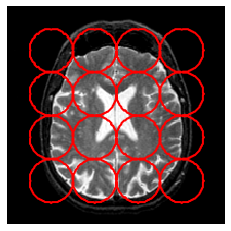

In [32]:
phi0 = np.ones_like(W)


for i in range(4):
    for j in range(4):
        phi0 = phi0*(np.sqrt(((X-1)/n -0.2*(i+1))**2+((Y-1)/n -0.2*(1+j))**2) - 0.1)
        
phi0 = perform_redistancing(phi0)


plot_levelset(phi0,0,f0)
# grille = np.zeros_like(phi0)

# grille[np.int(np.arange(0.2,0.8,0.2)*n),np.int(n*np.arange(0.2,0.8,0.2))]=1

The minimizing flow for the CV energy reads
$$ \pd{\phi_t}{t} = - G(\phi_t) $$
where
$$ G(\phi) =
- W \norm{\nabla \phi} \text{div}\pa{
	\frac{\nabla \phi}{\norm{\nabla \phi}}
} + \la (f_0-c_1)^2 - \la (f_0-c_2)^2. $$

Parameters

In [33]:
lambd = 2
c1 = .7
c2 = 0
tau = .5
Tmax = 500
niter = int(Tmax/ tau)

__Exercise 7__

Implement the full gradient descent that minimizes the Chan-Vese energy

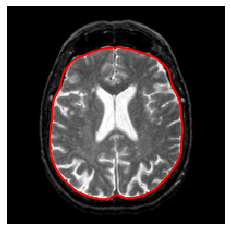

In [34]:
phi = np.copy(phi0)

for i in range(niter):
    grad_phi = grad(phi, order=2)
    norm_grad_phi = np.sqrt(np.sum(grad_phi**2, 2))
    normalized_gradient = grad_phi/(np.repeat(norm_grad_phi[:,:,np.newaxis],2,axis=-1)+eps)
    G = -W*norm_grad_phi*div(normalized_gradient[:,:,0],normalized_gradient[:,:,1],order=2) - lambd*(f0-c1)**2 + lambd*(f0-c2)**2

    phi = phi-tau*G
    
    if i%30==0:
        phi = perform_redistancing(phi)
    
plot_levelset(phi,0,f0)

## Want to go further?

Here is a list of what you can try:

1. Try to segment other images
2. Change the parameters values and observe the results
3. For Chan-Vese, we shouldn't assume $(c1, c2)$ are known. We want to optimize over $(\gamma, c1, c2)$. In order to do so, implement an iterative scheme similiar to K-means:
    1. $(c1, c2)$ are fixed, one step of $\gamma$ update
    2. $\gamma$ is fixed, update $(c1, c2)$ by computing the average color in the regions

## You're finished!

Once you've finished the lab, export it into a fixed HTML file and email it to me. You can follow these steps:

1. Export to HTML using the menu `File` > `Download as` > `HTML (.html)`
2. Rename the file using the following scheme: `TP3_nom_prenom.html`, for instance `TP3_dupont_jean.html`
3. Send it to the following address: groscot@ceremade.dauphine.fr

###### .THE END.